# Movie Recommendation System->
## Approach->
1) We will create embeddings based approach and make use of Matrix factorization to find the latent factors.
2) What is embeddings?
3) What is matrix factorization?
4) What are latent factors?
* The main idea is to predict the reaction of a user based on reaction of similar users
* We create embeddings of user and movies which in easy is for decreasing dimensionality and create vectors to pass it to the deep learning algorithm
* Matrix factorization is technique in simple terms which we split matrix in two parts for example ratings of user and movies into two parts and useing it to guess new ratings.
* Latent factors are the dimensions of features we split our embeddings into. Those feature could tell us about genre,timestamp,famous actor impact or some other feature which we might not even understand

### Deep Learning based Apprach using Tensorflow
We will use it to create embeddings and adding layers for predictions

In [1]:
# import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow libraries
from tensorflow import keras 
import tensorflow as tf
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint 
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding

 ### Dataset
 Movielens 1m 
GroupLens Research has collected and made available rating data sets from the MovieLens web site (https://movielens.org). The data sets were collected over various periods of time, depending on the size of the set. Before using these data sets, please review their README files for the usage licenses and other details.

In [2]:
base_path = '..' #/Users/akshatpandey/Thesisproject/Movie recommendation/data/ratings.csv

In [3]:
ratings = pd.read_csv(base_path + '//data//ratings.csv', sep='\t', encoding='latin-1', 
                      usecols=['user_id', 'movie_id', 'user_emb_id', 'movie_emb_id', 'rating'])

In [4]:
ratings

,user_id,movie_id,rating,user_emb_id,movie_emb_id
0,1,1193,5,0,1192
1,1,661,3,0,660
2,1,914,3,0,913
3,1,3408,4,0,3407
4,1,2355,5,0,2354
...,...,...,...,...,...
1000204,6040,1091,1,6039,1090
1000205,6040,1094,5,6039,1093
1000206,6040,562,5,6039,561
1000207,6040,1096,4,6039,1095


In [5]:
users = pd.read_csv(base_path + '/data/users.csv', sep='\t', encoding='latin-1', 
                    usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc'])

In [6]:
users

,user_id,gender,zipcode,age_desc,occ_desc
0,1,F,48067,Under 18,K-12 student
1,2,M,70072,56+,self-employed
2,3,M,55117,25-34,scientist
3,4,M,02460,45-49,executive/managerial
4,5,M,55455,25-34,writer
...,...,...,...,...,...
6035,6036,F,32603,25-34,scientist
6036,6037,F,76006,45-49,academic/educator
6037,6038,F,14706,56+,academic/educator
6038,6039,F,01060,45-49,other or not specified


In [7]:
movies = pd.read_csv(base_path + '/data/movies.csv', sep='\t', encoding='latin-1', 
                     usecols=['movie_id', 'title', 'genres'])

In [8]:
movies

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


### This is how user-movied matrix looks like
* We will break this matrix into two parts 
  user and movieid matrix 
* This is we called low rank matrix factorization.

In [9]:
final_dataset = ratings.pivot(index='movie_id',columns='user_id',values='rating')
final_dataset.head(10)

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,5.0,5.0,...,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,2.0,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Create training set
shuffled_ratings = ratings.sample(frac=1., random_state=42)
# Shuffling users
Users = shuffled_ratings['user_id'].values
print('Users:', Users, ', shape =', Users.shape)

# Shuffling movies
Movies = shuffled_ratings['movie_id'].values
print('Movies:', Movies, ', shape =', Movies.shape)

# Shuffling ratings
Ratings = shuffled_ratings['rating'].values
print('Ratings:', Ratings, ', shape =', Ratings.shape)

Users: [5412 5440  368 ...  854 4033  786] , shape = (1000209,)
Movies: [2683  904 3717 ... 3102 3479 1391] , shape = (1000209,)
Ratings: [2 5 4 ... 3 5 4] , shape = (1000209,)


### now we will make the function to create our embeddings of user and movies

In [11]:
def CFModel(n_users, m_items, latent_factors):
    """
    The model expects
    n_users:-No of users
    m_items:- No of items
    latent_factors:- No of dimensions the data has to be structures
    
    The function makes embedding of user and movie.
    
    
    """
    
    
    user = Input(shape=(1,))
    P = Embedding(n_users, latent_factors, input_length=1, name='user-embed')(user)
    P = Reshape((latent_factors,), name="user-reshape")(P)
    
    movie = Input(shape=(1,))
    Q = Embedding(m_items, latent_factors, input_length=1, name='movie-embed')(movie)
    Q = Reshape((latent_factors,), name="movie-reshape")(Q)
    
    P_dot_Q = Dot(axes=1, name="dot_product")([P,Q])
    model = Model(inputs=[user, movie], outputs=P_dot_Q, name="output")

    return model

We will define the number of latent factors we need.This can be tuned to make the prediction better latter.
Right now let us take the number of latent features to be 128
latent_factors = 128

In [12]:
latent_factors =128
n_userid = ratings['user_id'].drop_duplicates().max()
n_movieid = ratings['movie_id'].drop_duplicates().max()

In [13]:
n_userid,n_movieid

(6040, 3952)

In [14]:
# Define model
model = CFModel(n_userid, n_movieid, latent_factors)
# Compile the model using MSE as the loss function and the AdaMax learning algorithm
model.compile(loss='mse', optimizer='adamax')

Metal device set to: Apple M1


2023-11-14 10:24:19.660729: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-14 10:24:19.660825: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [15]:
model.summary()

Model: "output"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user-embed (Embedding)         (None, 1, 128)       773120      ['input_1[0][0]']                
                                                                                                  
 movie-embed (Embedding)        (None, 1, 128)       505856      ['input_2[0][0]']                
                                                                                             

In [16]:
def plot_model(model):
    return tf.keras.utils.plot_model(
            model, show_shapes=True, expand_nested=True)

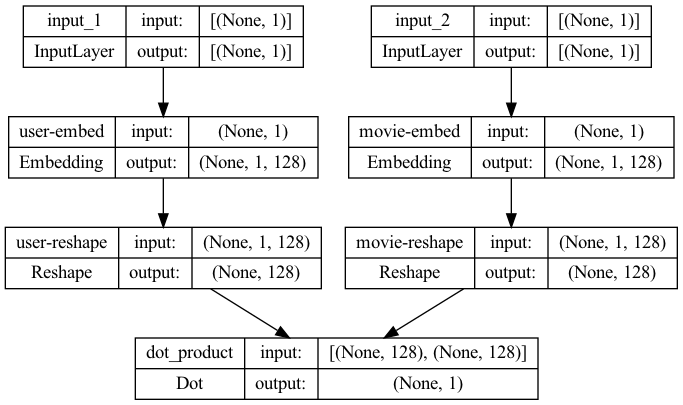

In [17]:
plot_model(model)

In [18]:
# Callbacks monitor the validation loss
# Save the model weights each time the validation loss has improved with early stopping
callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(base_path + '//data//' + 'baseline_weights.h5', save_best_only=True)] 
             


history = model.fit([Users, Movies], Ratings, epochs=15, validation_split=.1, verbose=2, callbacks=callbacks)

Epoch 1/15


2023-11-14 10:24:20.605514: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-11-14 10:24:20.835229: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-11-14 10:27:52.219348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


28131/28131 - 218s - loss: 13.6965 - val_loss: 11.9339 - 218s/epoch - 8ms/step
Epoch 2/15
28131/28131 - 217s - loss: 7.4547 - val_loss: 4.5504 - 217s/epoch - 8ms/step
Epoch 3/15
28131/28131 - 217s - loss: 3.3731 - val_loss: 2.6039 - 217s/epoch - 8ms/step
Epoch 4/15
28131/28131 - 219s - loss: 2.1569 - val_loss: 1.8615 - 219s/epoch - 8ms/step
Epoch 5/15
28131/28131 - 219s - loss: 1.6366 - val_loss: 1.4996 - 219s/epoch - 8ms/step
Epoch 6/15
28131/28131 - 219s - loss: 1.3642 - val_loss: 1.2949 - 219s/epoch - 8ms/step
Epoch 7/15
28131/28131 - 217s - loss: 1.2029 - val_loss: 1.1692 - 217s/epoch - 8ms/step
Epoch 8/15
28131/28131 - 221s - loss: 1.0994 - val_loss: 1.0848 - 221s/epoch - 8ms/step
Epoch 9/15
28131/28131 - 224s - loss: 1.0286 - val_loss: 1.0256 - 224s/epoch - 8ms/step
Epoch 10/15
28131/28131 - 217s - loss: 0.9776 - val_loss: 0.9827 - 217s/epoch - 8ms/step
Epoch 11/15
28131/28131 - 218s - loss: 0.9389 - val_loss: 0.9498 - 218s/epoch - 8ms/step
Epoch 12/15
28131/28131 - 218s - loss: 

In [19]:
history.history

{'loss': [13.696502685546875,
  7.454724311828613,
  3.3731203079223633,
  2.156935691833496,
  1.6366386413574219,
  1.3641517162322998,
  1.2028822898864746,
  1.099376916885376,
  1.0286471843719482,
  0.9775604605674744,
  0.9389376640319824,
  0.9083877205848694,
  0.8831571936607361,
  0.8617196083068848,
  0.8432326316833496],
 'val_loss': [11.933938980102539,
  4.550421714782715,
  2.6039254665374756,
  1.8615238666534424,
  1.4996027946472168,
  1.2949366569519043,
  1.1692290306091309,
  1.0848184823989868,
  1.0255542993545532,
  0.9827454090118408,
  0.9498119354248047,
  0.9236134886741638,
  0.9028533101081848,
  0.8846853375434875,
  0.8699503540992737]}

In [20]:
min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(history.history['val_loss']))
print('Minimum RMSE at epoch', '{:d}'.format(idx+1), '=', '{:.4f}'.format(math.sqrt(min_val_loss)))

Minimum RMSE at epoch 15 = 0.9327


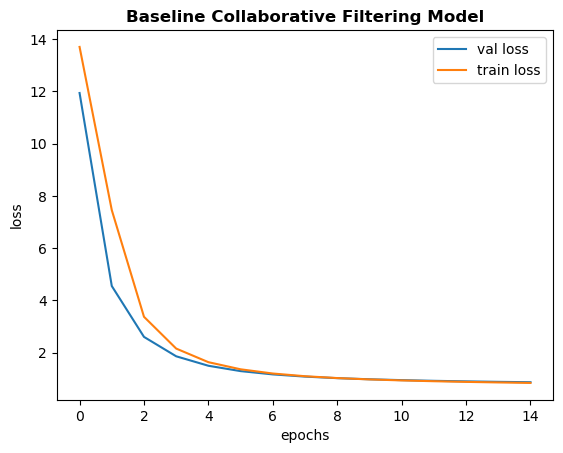

In [21]:
# baseline model loss plot in matplotlib
plt.plot(history.history['val_loss'], label="val loss")
plt.plot(history.history['loss'],  label="train loss")
plt.title('Baseline Collaborative Filtering Model', fontweight='bold')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
#plt.savefig(base_path + '/figures/plt/' + 'Baseline Collaborative Filtering Model.jpg',bbox_inches='tight')
plt.show()

In [22]:
# Load weights
model.load_weights(base_path + '//data//' + 'baseline_weights.h5')
model.summary()

Model: "output"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 user-embed (Embedding)         (None, 1, 128)       773120      ['input_1[0][0]']                
                                                                                                  
 movie-embed (Embedding)        (None, 1, 128)       505856      ['input_2[0][0]']                
                                                                                             

In [24]:
TEST_USER=1500

In [25]:
users[users['user_id'] == TEST_USER]

,user_id,gender,zipcode,age_desc,occ_desc
1499,1500,M,98115,25-34,technician/engineer


In [26]:
# Function to predict the ratings given User ID and Movie ID
def predict_rating(model, user_id, movie_id):
    return model.predict([np.array([user_id]), np.array([movie_id])])[0][0]

In [27]:
user_ratings = ratings[ratings['user_id'] == TEST_USER][['user_id', 'movie_id', 'rating']]
user_ratings['prediction'] = user_ratings.apply(lambda x: predict_rating(model, TEST_USER, x['movie_id']),axis=1)

1/1 [==============================] - 0s 8ms/step


2023-11-14 11:26:03.567428: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 7ms/step


In [28]:
user_ratings.sort_values(by='rating', 
                         ascending=False).merge(movies, 
                                                on='movie_id', 
                                                how='inner'
                                                ).head(20)

,user_id,movie_id,rating,prediction,title,genres
0,1500,1240,5,4.492089,"Terminator, The (1984)",Action|Sci-Fi|Thriller
1,1500,231,5,3.452276,Dumb & Dumber (1994),Comedy
2,1500,2683,5,3.746486,Austin Powers: The Spy Who Shagged Me (1999),Comedy
3,1500,296,5,4.752903,Pulp Fiction (1994),Crime|Drama
4,1500,2858,5,4.914405,American Beauty (1999),Comedy|Drama
5,1500,1136,5,4.677547,Monty Python and the Holy Grail (1974),Comedy
6,1500,1307,5,4.330812,When Harry Met Sally... (1989),Comedy|Romance
7,1500,3911,5,4.230828,Best in Show (2000),Comedy
8,1500,1199,5,4.258460,Brazil (1985),Sci-Fi
9,1500,3897,5,4.503483,Almost Famous (2000),Comedy|Drama


In [29]:
recommendations = ratings[ratings['movie_id'].isin(user_ratings['movie_id']) == False][['movie_id']].drop_duplicates()
recommendations['prediction'] = recommendations.apply(lambda x: predict_rating(model, TEST_USER, x['movie_id']), axis=1)


1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 8ms/step


In [30]:
recommendations.sort_values(by='prediction',
                          ascending=False).merge(movies,
                                                 on='movie_id',
                                                 how='inner'
                                                 ).head(20)

,movie_id,prediction,title,genres
0,527,4.962053,Schindler's List (1993),Drama|War
1,260,4.937712,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
2,1198,4.915251,Raiders of the Lost Ark (1981),Action|Adventure
3,858,4.900271,"Godfather, The (1972)",Action|Crime|Drama
4,2028,4.864816,Saving Private Ryan (1998),Action|Drama|War
5,1193,4.821140,One Flew Over the Cuckoo's Nest (1975),Drama
6,1196,4.794580,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
7,608,4.750639,Fargo (1996),Crime|Drama|Thriller
8,1148,4.747088,"Wrong Trousers, The (1993)",Animation|Comedy
9,110,4.689861,Braveheart (1995),Action|Drama|War


In [31]:
user_ratings

,user_id,movie_id,rating,prediction
248464,1500,3791,1,3.076358
248465,1500,3793,3,4.043419
248466,1500,2054,3,2.943358
248467,1500,1257,3,4.024396
248468,1500,2997,5,4.579325
...,...,...,...,...
248574,1500,1223,4,4.461544
248575,1500,1080,5,4.197379
248576,1500,3911,5,4.230828
248577,1500,1230,5,4.321844
